## Import the libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml  #using openml to import data
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV      
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer #transform different types

## Load in the data

In [17]:
X_initial, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)
combine_dataset = pd.concat([X_initial, y], axis=1)
combine_dataset.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",1
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",1
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",0
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON",0
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",0


Save the data for R:

In [42]:
combine_dataset.to_csv('/Users/kaifangzhou/Desktop/titanic_openml.csv', index=None)

## 1. Extend the results with more variables 

### Add the variable that is in previous analysis

In [18]:
combine_dataset['family size'] = combine_dataset['sibsp'] + combine_dataset['parch'] + 1

### Pipelines: Pre-Processing Stage

In [19]:
features = ['age', 'fare', 'embarked', 'sex', 'pclass', 'family size']
X = combine_dataset[features].copy()

In [20]:
#Check out features
X.head()

,age,fare,embarked,sex,pclass,family size
0,29.0000,211.3375,S,female,1.0,1.0
1,0.9167,151.5500,S,male,1.0,4.0
2,2.0000,151.5500,S,female,1.0,4.0
3,30.0000,151.5500,S,male,1.0,4.0
4,25.0000,151.5500,S,female,1.0,4.0


In [6]:
numerical_features = ['age', 'fare', 'family size']

# Applying SimpleImputer and StandardScaler into a pipeline
# SimpleImputer() (imputing either the mean or the median of the observations of each variable)
# Scaling with the function StandardScaler()

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())])

categorical_features = ['embarked', 'sex', 'pclass']

# Applying SimpleImputer and then OneHotEncoder into another pipeline
# OneHotEncoder() encode categorical features as a one-hot numeric array.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer()),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])


# Having pre-processed the numerical and categorical features separately.
# We can now merge them with the function ColumnTransformer()in which we specify the two pipelines to be merged using the argument transformers. 
# This creates a new pipeline called data_transformer.

data_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_features),
        ('categorical', categorical_transformer, categorical_features)]) 


## Create the test and training sets

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=1)

To tune the pipeline we can use cross-validation for each combination of its hyperparameters. In other words we can use grid search cross-validation that can be done with the function GridSearchCV(). This requires setting up a parameter grid, which is a dictionary containing the names of each hyperparameter followed by its range of values. The hyperparameters to be tuned below are the imputation strategies used in SimpleImputer(). In the case of numerical variables there are two options, mean or median. For categorical variables one option is to impute the most frequent value of each variable (most_frequent), whereas another option is to impute the missing value to be the reference category (constant with filled value being left to the default of 0). The best possible combination is chosen based on fitting the models on the training data.



Note: Grid Search cross-validation is a technique to select the best of the machine learning model, parameterized by a grid of hyperparameters.

### Set the parameter grid

In [21]:
param_grid = {
    'data_transformer__numerical__imputer__strategy': ['mean', 'median'],
    'data_transformer__categorical__imputer__strategy': ['constant','most_frequent']
}

### Extend the results: logistic regression

In [22]:
# Complete the machine learning pipeline by simply attaching a learner to the data_transformer pipeline from the previous section

pipe_lr = Pipeline(steps=[('data_transformer', data_transformer),
                      ('pipe_lr', LogisticRegression(max_iter=10000, penalty = 'none'))])

grid_lr = GridSearchCV(pipe_lr, param_grid=param_grid)

grid_lr.fit(X_train, y_train);


### Extend the results: gradient boosting

Let us consider also the Gradient Boosting learner. For simplicity we do not explore tuning the hyperparameters of this learner and simply use the default values for them. Hence, the code is very similar as before, we do add the argument random_state=2 to ensure reproducible results.

In [10]:
pipe_gdb = Pipeline(steps=[('data_transformer', data_transformer),
       ('pipe_gdb',GradientBoostingClassifier(random_state=2))])

grid_gdb = GridSearchCV(pipe_gdb, param_grid=param_grid)

grid_gdb.fit(X_train, y_train);

## 2. Extend the results with other classification methods

S2 mentioned the following classification methods that are not demonstrated in T2:

* Penalised logistic regression
* Classification trees
* Random forests
* Gaussian process classification
* Support vector machines 

### Penalised logistic regression

In [23]:
pipe_plr = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_plr', LogisticRegression(penalty='l1', max_iter=10000, tol=0.01, solver='saga'))])

grid_plr = GridSearchCV(pipe_plr, param_grid=param_grid)

grid_plr.fit(X_train, y_train);

### Classification tree

In [24]:
pipe_tree = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_tree', DecisionTreeClassifier(random_state=0))])

grid_tree = GridSearchCV(pipe_tree, param_grid=param_grid)

grid_tree.fit(X_train, y_train);

### Random forests

In [25]:
pipe_rf = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_rf', RandomForestClassifier(random_state=0))])

grid_rf = GridSearchCV(pipe_rf, param_grid=param_grid)

grid_rf.fit(X_train, y_train);

### Gaussian process classification

In [26]:
kernel = 1.0 * RBF(1.0)

pipe_gp = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_gp',  GaussianProcessClassifier(kernel=kernel, random_state=0))])

grid_gp = GridSearchCV(pipe_gp, param_grid=param_grid)
grid_gp.fit(X_train, y_train);

### Support vector machines

In [27]:
pipe_svm = Pipeline(steps=[('data_transformer', data_transformer),
                           ('pipe_svm',  LinearSVC(random_state=0, max_iter=10000, tol=0.01))])

grid_svm = GridSearchCV(pipe_svm, param_grid=param_grid)

grid_svm.fit(X_train, y_train);

## Compare the performance of the classification models by the ROC curve

/Users/kaifangzhou/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/kaifangzhou/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/kaifangzhou/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`

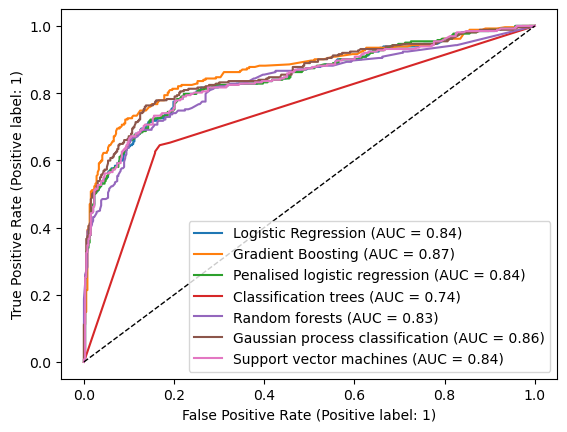

In [28]:
ax = plt.gca()
plot_roc_curve(grid_lr, X_test, y_test, ax=ax, name='Logistic Regression')
plot_roc_curve(grid_gdb, X_test, y_test, ax=ax, name='Gradient Boosting')
plot_roc_curve(grid_plr, X_test, y_test, ax=ax, name='Penalised logistic regression')
plot_roc_curve(grid_tree, X_test, y_test, ax=ax, name='Classification trees')
plot_roc_curve(grid_rf, X_test, y_test, ax=ax, name='Random forests')
plot_roc_curve(grid_gp, X_test, y_test, ax=ax, name='Gaussian process classification')
plot_roc_curve(grid_svm, X_test, y_test, ax=ax, name='Support vector machines')
plt.plot([0, 1], [0, 1], color='black', lw=1, linestyle='--')
plt.show()